## Title - Analyse a data set which contains contains images of rice leaf. There are three classes/diseases: Bacterial leaf blight, Brown spot, and Leaf smut
The goal of our analysis is to classify the given image of rice leaf into one of the three classes as mentioned in the title.

### Let's start by importing the data

In [35]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [36]:
IMAGE_SIZE=256
BATCH_SIZE=8
CHANNELS=3
EPOCHS=75

We have already extracted our image dataset in local directory : 'RiceLeaf'<br>
RiceLeaf directory will be having 3 folders, one for each individual class.

In [37]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory='RiceLeaf',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [38]:
class_names=dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [39]:
len(dataset)

15

In [40]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)

(8, 256, 256, 3)
tf.Tensor([0 2 2 1 0 2 0 2], shape=(8,), dtype=int32)


### Let's visualize the images

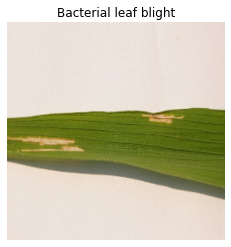

In [41]:
plt.imshow(image_batch[0].numpy().astype('uint8'))
plt.title(class_names[label_batch[0]])
plt.axis('off')
plt.show()

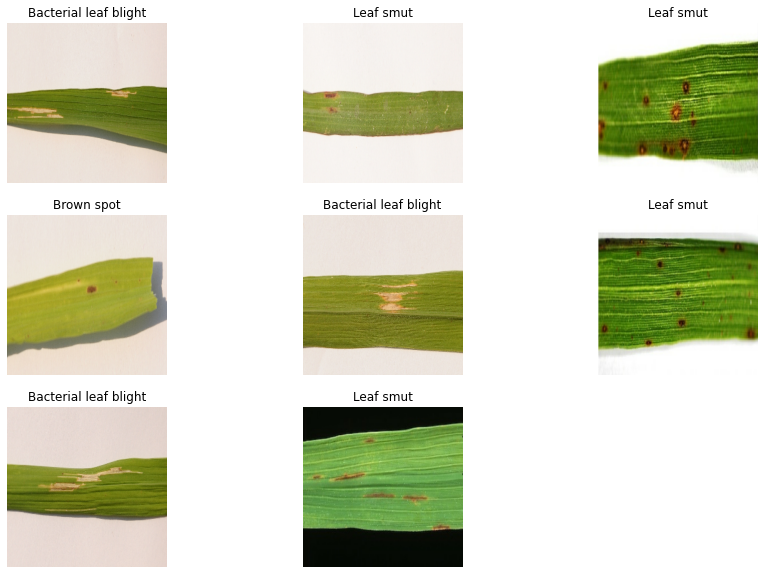

In [42]:
plt.figure(figsize=(15,10))

for i in range(8) :
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

### Let's split the datasets into train,test,validation set

80% ==> training<br>
20% ==> 10% validation ,10% test

In [43]:
train_size=0.80
len(dataset)*train_size

12.0

In [44]:
train_ds=dataset.take(12)
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
len(dataset)

15

### Let's write one function which can be used to split the dataset into train,test,validation set

In [46]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=42)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [47]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)

In [48]:
len(train_ds),len(val_ds),len(test_ds)

(12, 1, 2)

In [49]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Let's apply **Resizing** & **Rescaling** to the image<br>
Resizing - This layer resizes an image input to a target height and width.<br>
Rescaling - This layer rescales every value of an input image by multiplying by scale value.<br>

In [50]:
resize_and_rescale=tf.keras.Sequential([
                   layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                   layers.experimental.preprocessing.Rescaling(1.0/255)
])

Let's apply **Augmentation**<br>
As our dataset has only 40 images per class. This is not enough data to get good results.<br>
Image data augmentation is a technique to artificially increase the size of the training dataset using techniques like **Random Flip, Random Rotation**

In [51]:
data_augmentation=tf.keras.Sequential([
                  layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                  layers.experimental.preprocessing.RandomRotation(0.2)
])

### Build & train CNN model

In [52]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
      resize_and_rescale,
      data_augmentation,
      layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(units=64,activation='relu'),
      layers.Dense(n_classes,activation='softmax')   
])
model.build(input_shape=input_shape)

### Model Summary

In [53]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (8, 256, 256, 3)          0         
                                                                 
 sequential_4 (Sequential)   (8, 256, 256, 3)          0         
                                                                 
 conv2d_6 (Conv2D)           (8, 254, 254, 32)         896       
                                                                 
 max_pooling2d_6 (MaxPooling  (8, 127, 127, 32)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (8, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (8, 62, 62, 64)          0         
 2D)                                                  

In [54]:
model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
)

In [55]:
history=model.fit(
      train_ds,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      verbose=1,
      validation_data=val_ds
)

Epoch 1/75
12/12 [==============================] - 11s 744ms/step - loss: 1.1102 - accuracy: 0.2842 - val_loss: 1.0983 - val_accuracy: 0.2500
Epoch 2/75
12/12 [==============================] - 7s 574ms/step - loss: 1.0992 - accuracy: 0.3368 - val_loss: 1.0993 - val_accuracy: 0.2500
Epoch 3/75
12/12 [==============================] - 7s 561ms/step - loss: 1.0992 - accuracy: 0.3368 - val_loss: 1.0977 - val_accuracy: 0.2500
Epoch 4/75
12/12 [==============================] - 7s 562ms/step - loss: 1.0995 - accuracy: 0.3368 - val_loss: 1.0998 - val_accuracy: 0.2500
Epoch 5/75
12/12 [==============================] - 7s 563ms/step - loss: 1.0988 - accuracy: 0.3895 - val_loss: 1.0968 - val_accuracy: 0.6250
Epoch 6/75
12/12 [==============================] - 7s 559ms/step - loss: 1.0986 - accuracy: 0.3474 - val_loss: 1.0984 - val_accuracy: 0.2500
Epoch 7/75
12/12 [==============================] - 7s 563ms/step - loss: 1.0974 - accuracy: 0.3684 - val_loss: 1.0782 - val_accuracy: 0.5000
Epoch

In [56]:
scores=model.evaluate(test_ds)

2/2 [==============================] - 1s 152ms/step - loss: 0.3101 - accuracy: 0.8750


In [57]:
scores

[0.3100665211677551, 0.875]

### Let's plot training history

In [58]:
history.params

{'verbose': 1, 'epochs': 75, 'steps': 12}

In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [60]:
len(history.history['accuracy'])

75

In [61]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

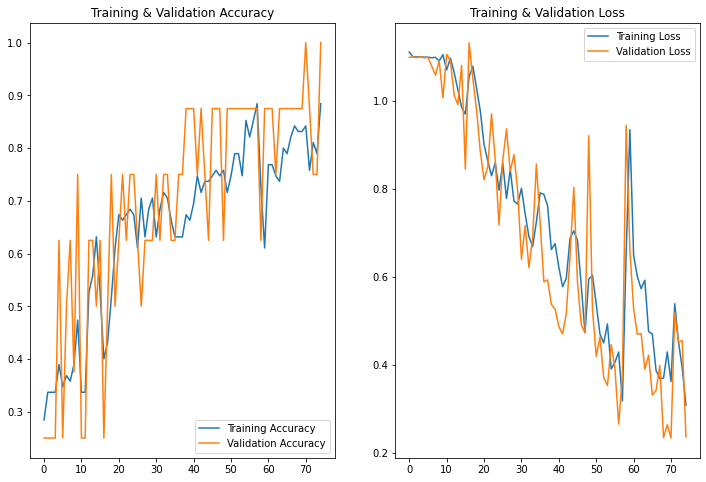

In [62]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

## Predicitons 

### Let's define one function for class prediction

In [63]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


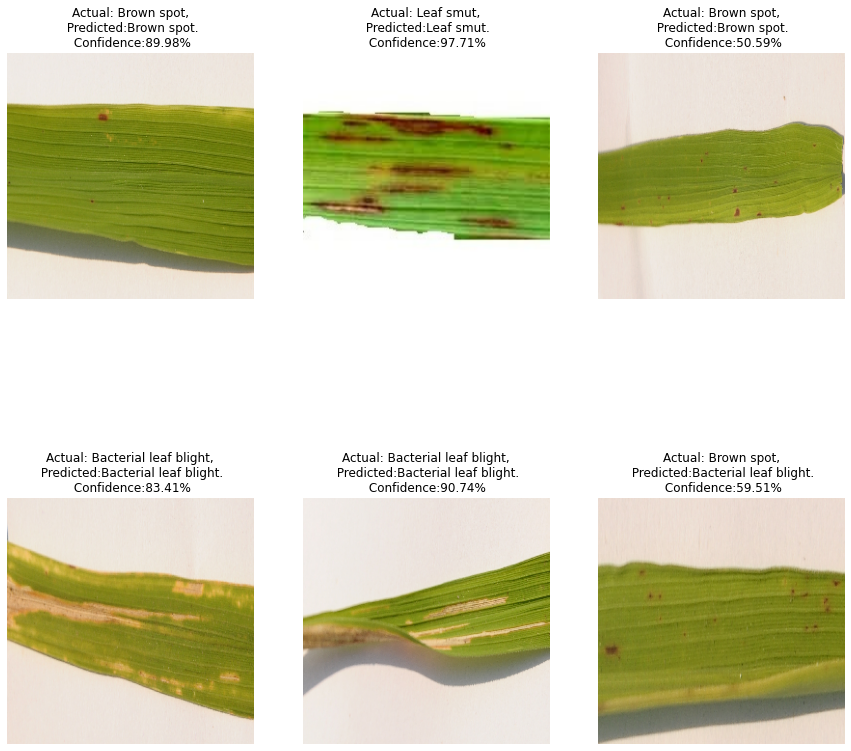

In [64]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax=plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%')
        
        plt.axis('off')
        

### Let's evaluate the model on the images which are not part of original dataset (downloaded from external source)

1/1 [==============================] - 0s 36ms/step
Predicted:Brown spot.
 Confidence:99.9%


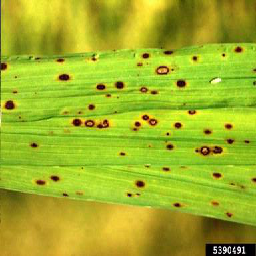

In [65]:
img=tf.keras.preprocessing.image.load_img('Test_img3.jpg',target_size=(256,256,3))
img_array1 = tf.keras.preprocessing.image.img_to_array(img)
img_array1= tf.expand_dims(img_array1,0)

predictions1=model.predict(img_array1)

predicted_class = class_names[np.argmax(predictions1[0])]
confidence=round(100*(np.max(predictions1[0])),2)
print((f'Predicted:{predicted_class}.\n Confidence:{confidence}%'))
img

-  Actual class : Brown spot
-  Predicted : Brown spot

### So our model has predicted the class correctly for the above case.

Let's try on one more image

1/1 [==============================] - 0s 33ms/step
Predicted:Leaf smut.
 Confidence:100.0%


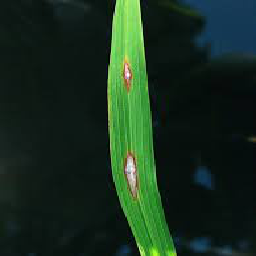

In [66]:
img=tf.keras.preprocessing.image.load_img('Test_img.jpg',target_size=(256,256,3))
img_array1 = tf.keras.preprocessing.image.img_to_array(img)
img_array1= tf.expand_dims(img_array1,0)

predictions1=model.predict(img_array1)

predicted_class = class_names[np.argmax(predictions1[0])]
confidence=round(100*(np.max(predictions1[0])),2)
print((f'Predicted:{predicted_class}.\n Confidence:{confidence}%'))
img

-  Actual class : Bacterial leaf blight
-  Predicted : Leaf smut

**So our model has failed to predict the class correctly for the above case.**

## Conclusion:

### We have successfully predicted the class for an input image using our CNN model.
### Given that the model accuracy was around ~87%, few mistakes are bound to happen while predicting the class.